#### Sentiment Baselines (Guardian DRC)
The sentiment analysis will initially focus on:
Computing two baselines:
1) **VADER** (rule-based, fast)
2) **Transformer** (CardiffNLP RoBERTa, higher quality)

Outputs saved to:
- `data/processed/sentiment_vader.parquet`
- `data/processed/sentiment_xfm.parquet`


In [9]:
# Import the required libraries

import os, pandas as pd
from pathlib import Path
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import trange
import torch, pandas as pd


In [10]:
# Load the data
# Inputs / outputs
CLEAN = Path("../data/interim/guardian_clean.parquet")
OUT_VADER = Path("../data/processed/sentiment_vader.parquet")
OUT_XFM   = Path("../data/processed/sentiment_xfm.parquet")
OUT_VADER.parent.mkdir(parents=True, exist_ok=True)

# Sampling (set to None to run on FULL corpus)
N_VADER = 5000     # e.g., 5k for quick pass; set to None for full
N_XFM   = 2000     # transformers are slower; start small; set to None for full

assert CLEAN.exists(), f"Missing clean file: {CLEAN}. Run 01_clean_normalize first."

In [11]:
df = pd.read_parquet(CLEAN)
print("Loaded:", len(df), "rows")
df.head(5)

Loaded: 8745 rows


,pub_date,year,month,web_url,section_name,text
0,2000-01-08 01:33:31+00:00,2000,2000-01,https://www.theguardian.com/books/2000/jan/08/...,Books,"I took my family to the Dome this week (yes, w..."
1,2000-01-15 00:36:48+00:00,2000,2000-01,https://www.theguardian.com/world/2000/jan/15/...,World news,Evidence of direct Belgian government complici...
2,2000-01-20 02:37:25+00:00,2000,2000-01,https://www.theguardian.com/world/2000/jan/20/...,World news,Sordid details of the extent to which the Zimb...
3,2000-01-20 17:58:25+00:00,2000,2000-01,https://www.theguardian.com/politics/2000/jan/...,Politics,"Tony Blair has overuled the foreign secretary,..."
4,2000-01-21 17:35:59+00:00,2000,2000-01,https://www.theguardian.com/world/2000/jan/21/...,World news,The government effectively abandoned any prete...


#### Stratified Sampling
This will help keeps distribution across years roughly balanced while testing.

In [12]:
#Function to create the stratified sample
def stratified_sample(df, n=None, key="year", seed=42):
    if n is None or n >= len(df):
        return df
    per_key = max(1, n // df[key].nunique())
    parts = []
    for y, grp in df.groupby(key):
        parts.append(grp.sample(min(len(grp), per_key), random_state=seed))
    out = pd.concat(parts).sample(frac=1, random_state=seed).reset_index(drop=True)
    return out[:n]

df_vader = stratified_sample(df, N_VADER, key="year")
df_xfm   = stratified_sample(df, N_XFM,   key="year")
print("VADER sample:", len(df_vader), "Transformer sample:", len(df_xfm))


VADER sample: 4733 Transformer sample: 1976


#### VADER Baseline
VADER - Valence Aware Dictionary and sEntiment Reasoner. A rule-based sentiment analysis tool specifically designed for social media text and short, informal language.

- Lexicon-based: Uses a dictionary of words with associated sentiment scores.
- Handles social media quirks: Emoticons, slang, punctuation emphasis (!!!), capitalization.

Outputs:

- Positive, Negative, Neutral scores.
- Compound score: A normalized value between -1 (most negative) and +1 (most positive).

Great for tweets, comments, reviews, and short texts.
Lightweight and easy to implement in Python

In [6]:
from tqdm import tqdm
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

an = SentimentIntensityAnalyzer()

scores = [an.polarity_scores(t) for t in tqdm(df_vader["text"].tolist(), desc="VADER")]
vader_df = pd.DataFrame(scores)  # neg, neu, pos, compound

out_v = pd.concat([df_vader.reset_index(drop=True), vader_df], axis=1)
out_v.to_parquet(OUT_VADER, index=False)
print("Saved ->", OUT_VADER, "| rows:", len(out_v))
out_v.head(3)


VADER: 100%|████████████████████████████████| 4733/4733 [06:43<00:00, 11.73it/s]


Saved -> ../data/processed/sentiment_vader.parquet | rows: 4733


,pub_date,year,month,web_url,section_name,text,neg,neu,pos,compound
0,2013-08-22 16:19:22+00:00,2013,2013-08,https://www.theguardian.com/global-development...,Global development,The battle to eliminate polio has hit apparent...,0.091,0.861,0.048,-0.9902
1,2002-01-31 12:01:31+00:00,2002,2002-01,https://www.theguardian.com/theguardian/2002/j...,Global,"Harambee, or self-help, has a special meaning ...",0.046,0.822,0.133,0.9971
2,2008-10-31 12:24:37+00:00,2008,2008-10,https://www.theguardian.com/politics/2008/oct/...,Politics,October 30 session European Investment Bank Al...,0.147,0.729,0.124,-0.9908


#### Transformer Set Up

In [7]:
from transformers import pipeline
import torch

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"  # good general baseline
BATCH_SIZE = 16

# Device: auto GPU if available; else CPU
device = 0 if torch.cuda.is_available() else -1
device

/Users/domnjue/Desktop/sa-nlp-drc/sentiment-analysis/.venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/domnjue/Desktop/sa-nlp-drc/sentiment-analysis/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


-1

#### Transformer inference (batched)

In [13]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import trange
import torch, pandas as pd

MODEL_NAME = "cardiffnlp/twitter-roberta-base-sentiment-latest"
BATCH_SIZE = 16
MAX_LEN = 512  # roberta uses 512 (w/ special tokens => 514 internal)

# load tokenizer/model explicitly so we control max_length
tok = AutoTokenizer.from_pretrained(MODEL_NAME, use_fast=True, model_max_length=MAX_LEN)
mdl = AutoModelForSequenceClassification.from_pretrained(MODEL_NAME)
clf = pipeline("sentiment-analysis", model=mdl, tokenizer=tok, device=device)

def trim_empty(xs):
    # ensure non-empty strings
    return [x if (isinstance(x, str) and x.strip()) else "." for x in xs]

texts = trim_empty(df_xfm["text"].tolist())

preds = []
for i in trange(0, len(texts), BATCH_SIZE, desc="HF sentiment"):
    batch = texts[i:i+BATCH_SIZE]
    # HARDEN: enforce same shape via padding + truncation
    preds.extend(clf(batch, padding="max_length", truncation=True, max_length=MAX_LEN))

xfm_df = pd.DataFrame(preds).rename(columns={"label":"hf_label","score":"hf_score"})
out_x = pd.concat([df_xfm.reset_index(drop=True), xfm_df], axis=1)
out_x.to_parquet(OUT_XFM, index=False)
print("Saved ->", OUT_XFM, "| rows:", len(out_x))
out_x.head(3)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu
HF sentiment: 100%|███████████████████████████| 124/124 [02:40<00:00,  1.30s/it]

Saved -> ../data/processed/sentiment_xfm.parquet | rows: 1976


,pub_date,year,month,web_url,section_name,text,hf_label,hf_score
0,2024-06-11 13:00:02+00:00,2024,2024-06,https://www.theguardian.com/food/article/2024/...,Food,What sauces can you make in the time it takes ...,neutral,0.666770
1,2022-10-29 06:00:50+00:00,2022,2022-10,https://www.theguardian.com/environment/2022/o...,Environment,The goal of limiting global heating to 1.5C is...,neutral,0.502389
2,2008-09-17 14:07:40+00:00,2008,2008-09,https://www.theguardian.com/commentisfree/2008...,Opinion,It seems far too often we see images on our te...,negative,0.830148


#### Sanity Check

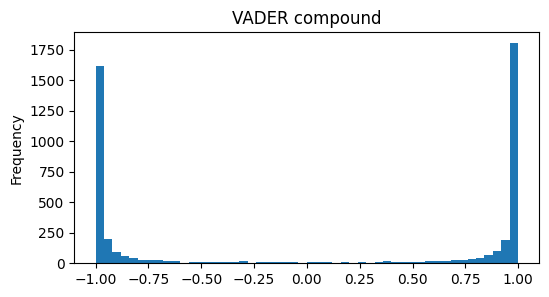

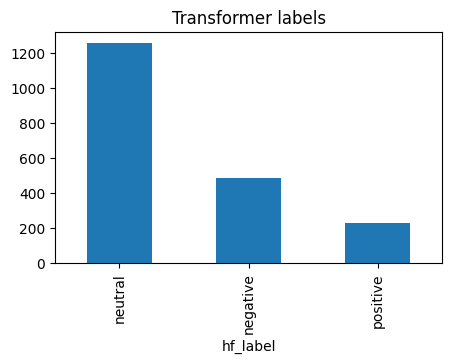

In [14]:
import matplotlib.pyplot as plt

# VADER compound distribution
if OUT_VADER.exists():
    v = pd.read_parquet(OUT_VADER)
    v["compound"].plot(kind="hist", bins=50, figsize=(6,3), title="VADER compound")
    plt.show()

# Transformer label distribution
if OUT_XFM.exists():
    x = pd.read_parquet(OUT_XFM)
    x["hf_label"].value_counts().plot(kind="bar", figsize=(5,3), title="Transformer labels")
    plt.show()

In [15]:
# Join the two outputs on web_url for the intersection of samples
if OUT_VADER.exists() and OUT_XFM.exists():
    v_small = pd.read_parquet(OUT_VADER)[["web_url","compound"]]
    x_small = pd.read_parquet(OUT_XFM)[["web_url","hf_label","hf_score"]]
    both = v_small.merge(x_small, on="web_url", how="inner")
    print("Overlap rows:", len(both))
    both.head(10)

Overlap rows: 1976
